In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import IPython.display as disp

import geemap



2024-05-08 11:37:34.166003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 11:37:35.180624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import ee
ee.Authenticate()
ee.Initialize(project="env-16-remote-sensing")

In [3]:
geometry = ee.Geometry.Point([9.269243, 45.4654219])
roi = geometry.buffer(25000)


collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
                .filterBounds(geometry) \
                .filterDate('2022-01-01', '2023-04-10') \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) \
                .sort("CLOUDY_PIXEL_PERCENTAGE") \
                .select('B2','B3','B4')


print(collection.size().getInfo())


29


In [4]:
collection.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()


[0.001712,
 0.112465,
 0.13278,
 0.33478,
 0.367482,
 0.401551,
 0.860038,
 0.90571,
 0.942787,
 0.954347,
 1.215958,
 1.336731,
 1.35251,
 1.472821,
 1.958619,
 2.017863,
 2.932207,
 3.022407,
 3.103338,
 3.621845,
 3.632055,
 3.676591,
 4.226599,
 4.480009,
 4.785138,
 5.860298,
 7.695011,
 8.567567,
 9.850558]

In [5]:
imageList = collection.toList(collection.size())

image = imageList.get(0)
image = ee.Image(image)

In [6]:
Map = geemap.Map()
vis_param = {'min': 0,
             'max': 3000,
             'bands': ['B4', 'B3', 'B2'],
             'gamma': 1.5}

Map.addLayer(image, vis_param, "First image")
Map.centerObject(geometry, 13)

Map

Map(center=[45.465421899999996, 9.269243000000001], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# gdexport = ee.batch.Export.image.toDrive(image.clip(roi),
#                                          description='driveExportTask_s2',
#                                          folder = 'gee',
#                                          fileNamePrefix = 's2_Milan_test_big',
#                                          scale = 10,
#                                          maxPixels = 1e11)
# gdexport.start()

In [8]:
# gdexport.status()

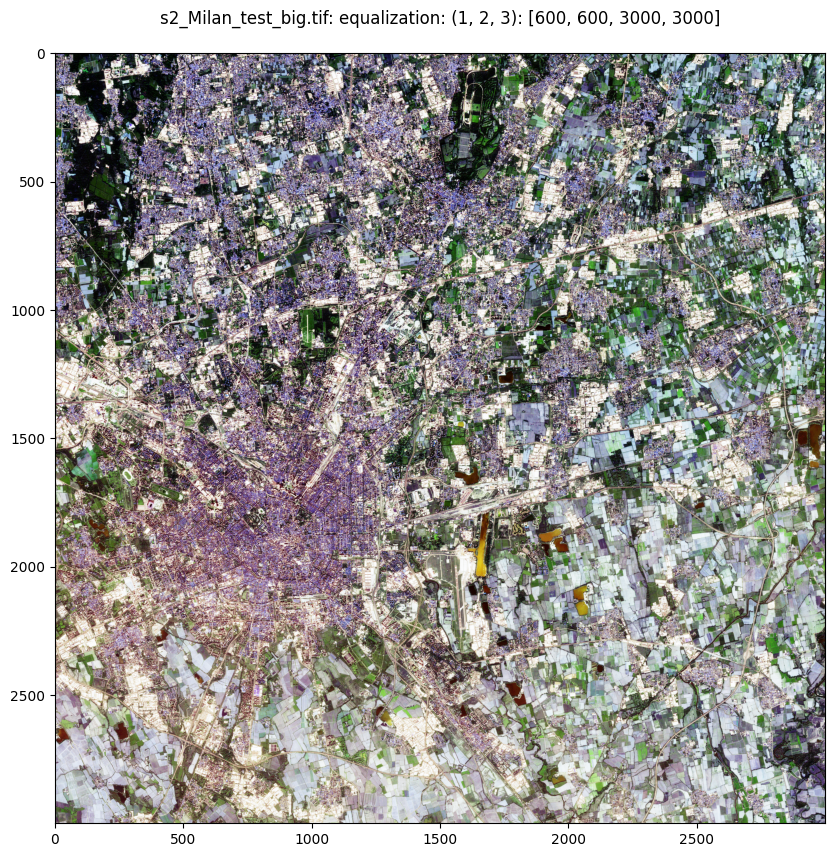

In [11]:
run scripts/dispms -f data/s2_Milan_test_big.tif -e 4 -p [1,2,3] -d [600,600,3000,3000]

In [13]:
run scripts/S2cnnclassify -d [600,600,3000,3000] -s 8 data/s2_Milan_test_big.tif

TypeError: Error when deserializing class 'SeparableConv2D' using config={'name': 'block2_sepconv1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}, 'shared_object_id': 21}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'pointwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to SeparableConv2D: {'groups': 1, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'kernel_regularizer': None, 'kernel_constraint': None}